In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [70]:
# 그래프 깨짐 방지
plt.rc('font', family='AppleGothic') 
plt.rc('axes', unicode_minus=False)
# 모든 컬럼이 다 보이도록 설정
pd.set_option('display.max_columns', None)

In [71]:
DATA_PATH = "../../data/raw"

In [72]:
train = pd.read_csv(DATA_PATH + '/train.csv')
train['voted'] = train['voted'].replace({1: 1, 2: 0})
train.drop('index', axis=1, inplace=True)

In [73]:
qa_cols = [f'Q{i}A' for i in 'abcdefghijklmnopqrst']
qe_cols = [f'Q{i}E' for i in 'abcdefghijklmnopqrst']

Q_A 처리

- 역채점 전/후 히트맵 (방향성 확인 / 처리 방법은 6 - 응답값)
- 데이터의 방향성 통일을 위한 작업
- 문항별 긍정/부정 방향을 일치시켜 점수의 합산 및 상관관계 분석이 가능하도록 정렬

- mach_score로 수치화 컬럼 생성
(역채점한게 학습에 영향을 크게 줄지는 아직 모르겠음)

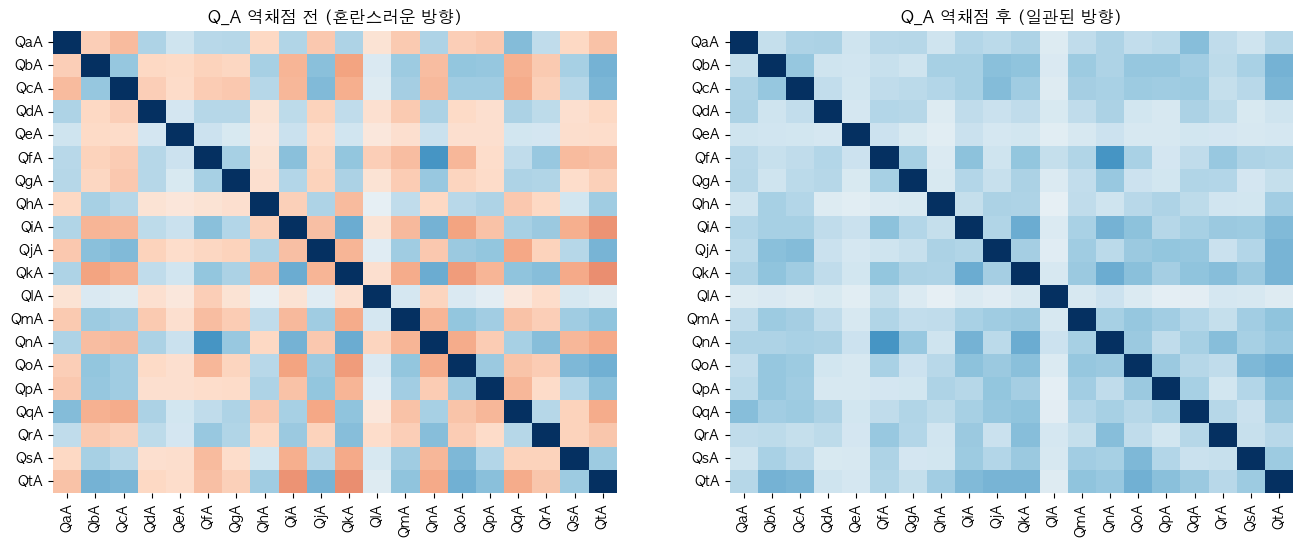

In [74]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.heatmap(train[qa_cols].corr(), cmap='RdBu', center=0, cbar=False)
plt.title("Q_A 역채점 전 (혼란스러운 방향)")

# 역채점 로직 실행
correlations = train[qa_cols].corr()
reference_col = correlations.sum().idxmax()
to_flip = correlations[reference_col][correlations[reference_col] < 0].index.tolist()
for col in to_flip:
    train[col] = 6 - train[col]

plt.subplot(1, 2, 2)
sns.heatmap(train[qa_cols].corr(), cmap='RdBu', center=0, cbar=False)
plt.title("Q_A 역채점 후 (일관된 방향)")
plt.show()

train['mach_score'] = train[qa_cols].mean(axis=1)

Q_E 처리

- 그래프상 위쪽 이상치 정리 (1% 클리핑 / 딴짓 등으로 인해 발생한 지연이라 생각됨)
- 그래프 쏠림 현상 처리 (로그처리)

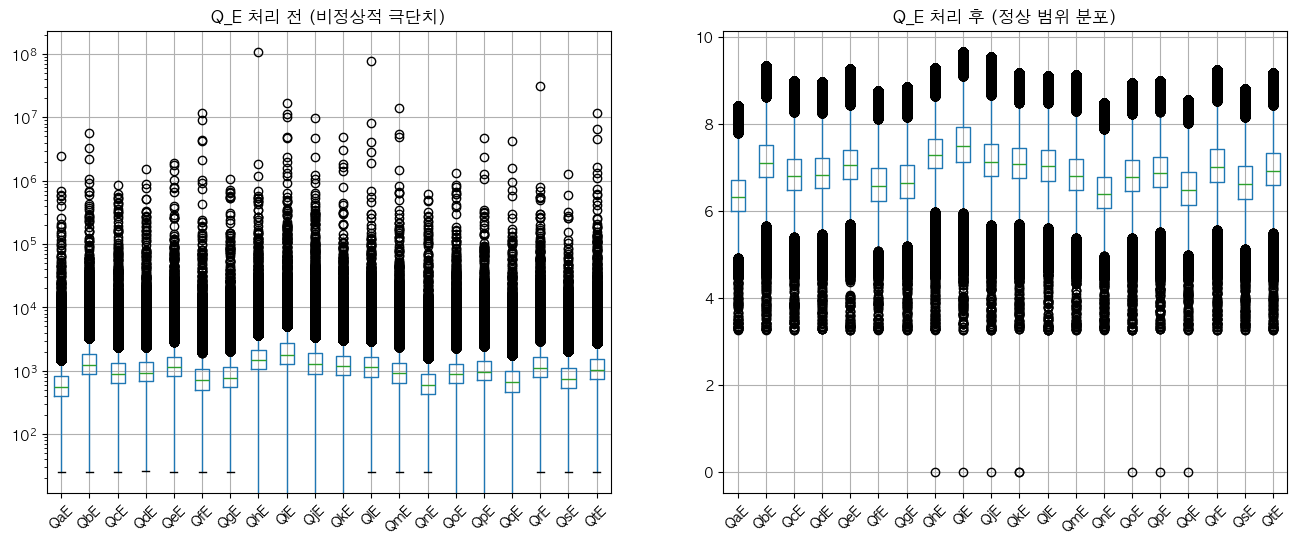

In [75]:
plt.figure(figsize=(16, 6))

# 처리 전: 이상치 의심
plt.subplot(1, 2, 1)
train[qe_cols].boxplot()
plt.yscale('log')
plt.title("Q_E 처리 전 (비정상적 극단치)")
plt.xticks(rotation=45)

# Q_E 전처리 적용 (Clipping + Log)
for col in qe_cols:
    train[col] = train[col].clip(upper=train[col].quantile(0.99))
train[qe_cols] = np.log1p(train[qe_cols])

# 처리 후: 이상치가 정리
plt.subplot(1, 2, 2)
train[qe_cols].boxplot()
plt.title("Q_E 처리 후 (정상 범위 분포)")
plt.xticks(rotation=45)
plt.show()

FamilySize
- 유난히 튀는 이상치 확인 -> 클리핑으로 정리 (1%: 8명 / 그 이후는 이상치로 판단)

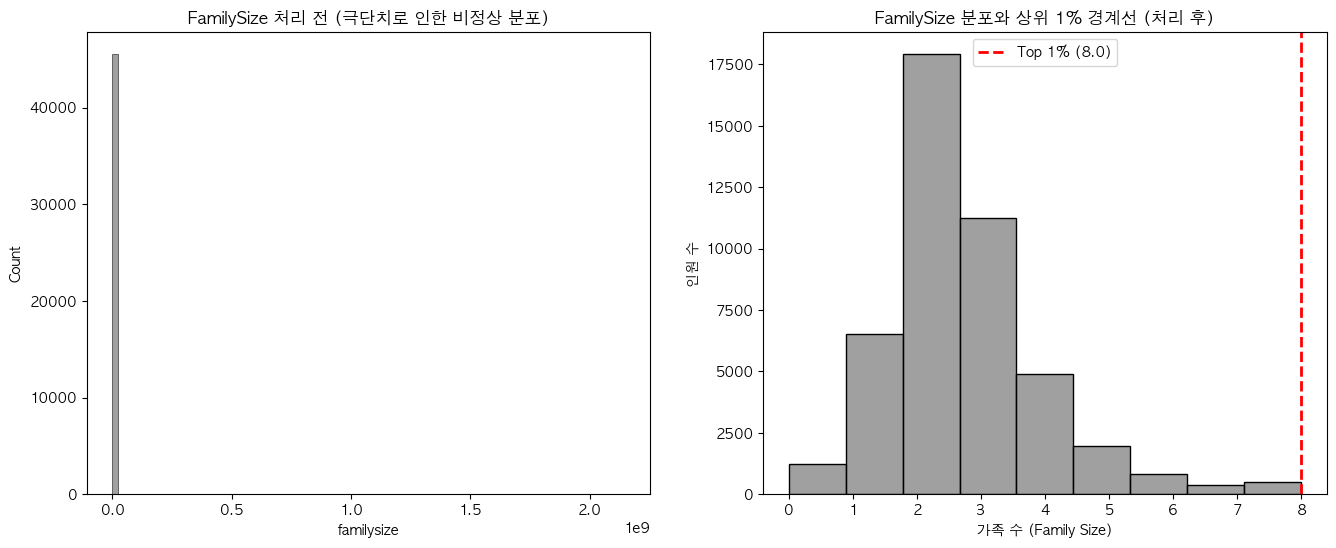

In [76]:
plt.figure(figsize=(16, 6))

# (전) 처리 전: 꼬리가 너무 길어서 대다수의 데이터가 0 근처에 뭉쳐 보임
plt.subplot(1, 2, 1)
sns.histplot(train['familysize'], bins=100, color='gray')
plt.title("FamilySize 처리 전 (극단치로 인한 비정상 분포)")

# (후) 처리 후: 1% 경계선을 표시하여 절단 근거 제시
f_limit = train['familysize'].quantile(0.99)
train['familysize'] = train['familysize'].clip(upper=f_limit)

plt.subplot(1, 2, 2)
sns.histplot(train['familysize'], bins=int(f_limit)+1, color='gray')
plt.axvline(f_limit, color='red', linestyle='--', linewidth=2, label=f'Top 1% ({f_limit})')
plt.title("FamilySize 분포와 상위 1% 경계선 (처리 후)")
plt.xlabel("가족 수 (Family Size)")
plt.ylabel("인원 수")
plt.legend()
plt.show()

age_group

- 0번의 투표율과 심리 점수가 고령층과 유사함 (0번(미상) -> 6번(고령) 병합)

/var/folders/q4/yj_kszs56h10dm1b5l1cmby00000gn/T/ipykernel_1219/2859823582.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.countplot(data=train, x='age_group', palette='pastel', order=sorted(train['age_group'].unique()))


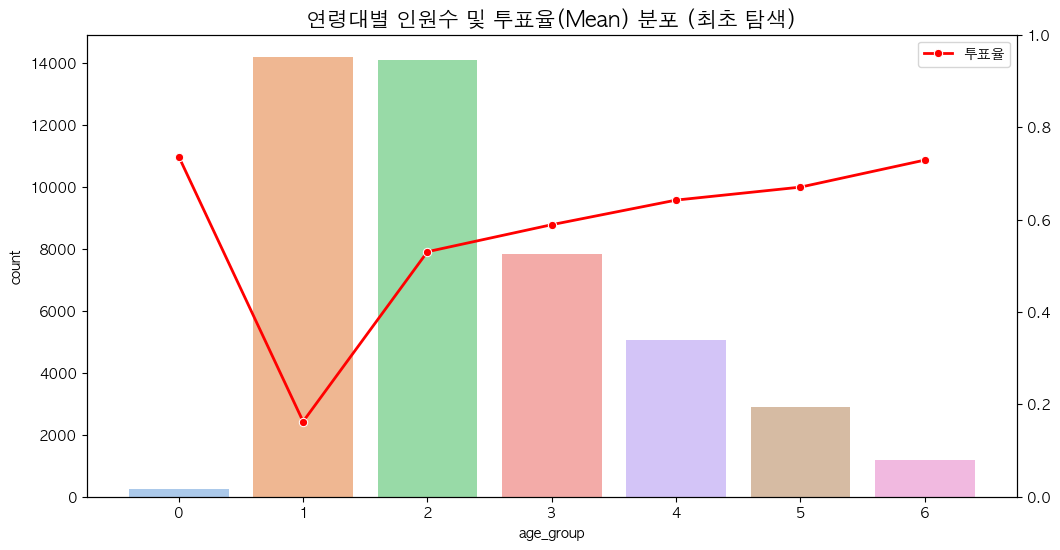

--- 연령대별 평균 mach_score 비교 ---
age_group
0    3.085319
1    2.461382
2    2.561558
3    2.725989
4    2.915076
5    3.052146
6    3.167755
Name: mach_score, dtype: float64


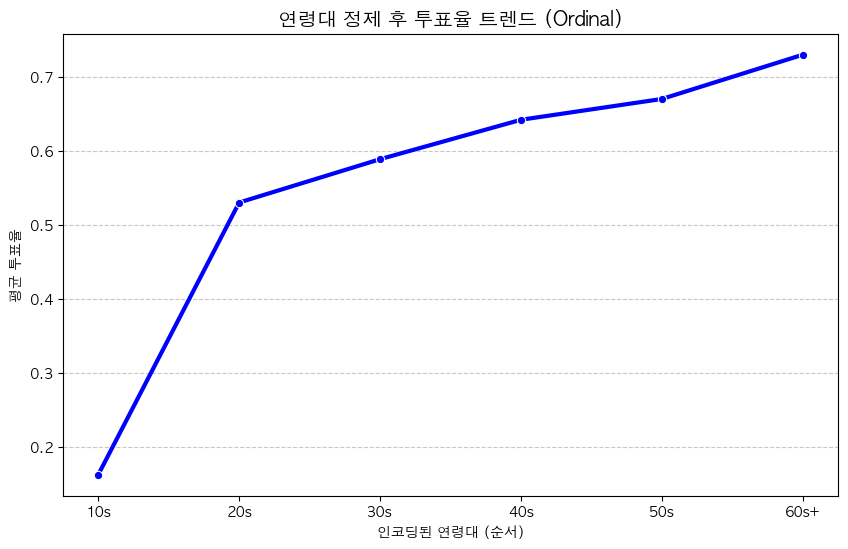

In [77]:
# 라벨인코딩
age_map = {val: i for i, val in enumerate(sorted(train['age_group'].unique()))}
train['age_group'] = train['age_group'].map(age_map)

# 0번의 비정상적인 그래프 확인 (특정구간에서 비정상적인 투표율)
plt.figure(figsize=(12, 6))
ax1 = sns.countplot(data=train, x='age_group', palette='pastel', order=sorted(train['age_group'].unique()))
plt.title('연령대별 인원수 및 투표율(Mean) 분포 (최초 탐색)', fontsize=15)

ax2 = ax1.twinx()
age_voted_mean = train.groupby('age_group')['voted'].mean().reindex(sorted(train['age_group'].unique()))
sns.lineplot(x=range(len(age_voted_mean)), y=age_voted_mean.values, color='red', marker='o', linewidth=2, ax=ax2, label='투표율')
ax2.set_ylim(0, 1)
plt.show()

# mach_score와 비교 -> 50~60대와 유사 -> 10대가 아닌 나이를 속인 고령층으로 추측
age_mach_comparison = train.groupby('age_group')['mach_score'].mean()
print("--- 연령대별 평균 mach_score 비교 ---")
print(age_mach_comparison)

# 0번을 유사한 6번(70+)그룹과 병합
train['age_group_cleaned'] = train['age_group'].replace({0: 6})

# 오디널 인코딩
age_map = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
train['age_encoded'] = train['age_group_cleaned'].map(age_map)

# 확인차 그래프
plt.figure(figsize=(10, 6))
final_trend = train.groupby('age_encoded')['voted'].mean()
sns.lineplot(x=final_trend.index, y=final_trend.values, marker='o', color='blue', linewidth=3)

plt.title("연령대 정제 후 투표율 트렌드 (Ordinal)", fontsize=14)
plt.xticks(ticks=[1,2,3,4,5,6], labels=['10s', '20s', '30s', '40s', '50s', '60s+'])
plt.xlabel("인코딩된 연령대 (순서)")
plt.ylabel("평균 투표율")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [78]:
# 0번 그룹만 추출하여 통계 확인
age_0 = train[train['age_group'] == 0]

print("--- 0번 그룹(age_group=0) 상세 정보 ---")
print(age_0['voted'].value_counts()) # 투표 여부별 실제 인원수
print("\n--- 0번 그룹 주요 변수 통계 ---")
display(age_0[['familysize', 'mach_score']].describe())

# 타 연령대와 mach_score(마키아벨리즘 점수) 비교
print("\n--- 연령대별 평균 마키아벨리즘 점수 ---")
print(train.groupby('age_group')['mach_score'].mean())

--- 0번 그룹(age_group=0) 상세 정보 ---
voted
1    173
0     62
Name: count, dtype: int64

--- 0번 그룹 주요 변수 통계 ---


,familysize,mach_score
count,235.000000,235.000000
mean,3.310638,3.085319
std,1.937400,0.826011
min,0.000000,1.000000
25%,2.000000,2.500000
50%,3.000000,3.200000
75%,4.000000,3.700000
max,8.000000,4.700000



--- 연령대별 평균 마키아벨리즘 점수 ---
age_group
0    3.085319
1    2.461382
2    2.561558
3    2.725989
4    2.915076
5    3.052146
6    3.167755
Name: mach_score, dtype: float64


gender
- set으로 봤을때 'Male', 'Female' 이진값뿐이었기 때문에 단순 매핑 적용

race, religion, education, urban, married, hand, engnat
- education 같은 순서에 의미가 있는 범주에서 0(무응답)의 처리 고민...
  -> 값이 커질수록 영향을 주도록 학습시킨다 > ordinel encoding
  -> 실제 투표 평균율을 따라 학습시킨다 > target encoding (voted)
- ordinel encoding의 경우 mean, median값으로 0(무응답)을 대체하거나 one-hot 병행
- target encoding의 경우 과적합 방지 생각할것

- 3가지 방법 (one-hot / ordinel / target)

One-Hot/Ordinal은 데이터의 '형태'를 바꾸는 것이고, Target Encoding은 데이터에 '정답의 힌트'를 미리 심는 것

Smoothing은 해당 범주의 데이터가 적으면 '전체 평균' 쪽으로 끌어당기고, 데이터가 많으면 '해당 범주 평균'을 따라가게 작업

범주가 많거나(race, religion), 무응답(0)의 의미를 타겟과의 관계 속에서 찾고 싶을 때 Smoothed Target Encoding을 사용하면 좋을 듯

In [79]:
def apply_smoothed_target_encoding(df, target_col, encode_cols, m=10):
    """
    Smoothing이 적용된 Target Encoding을 수행합니다.
    - df: 데이터프레임
    - target_col: 타겟 변수 명 ('voted')
    - encode_cols: 인코딩을 적용할 범주형 컬럼 리스트
    - m: Smoothing 계수 (데이터가 어느정도 이상 모여야 그 그룹의 성향을 믿어줄 것인가?에 대한 기준선, 5, 10, 20, 50으로 바꿔가며 AUC 확인)
    
    """
    df_encoded = df.copy()
    overall_mean = df[target_col].mean() # 전체 데이터의 투표율 평균

    for col in encode_cols:
        # 1. 각 범주별 통계 (개수와 평균) 계산
        stats = df.groupby(col)[target_col].agg(['count', 'mean'])
        
        # 2. Smoothing 공식 적용
        # (n * mean + m * overall_mean) / (n + m)
        smooth_values = (stats['count'] * stats['mean'] + m * overall_mean) / (stats['count'] + m)
        
        # 3. 원본 데이터에 매핑 (새로운 컬럼 생성 또는 대체)
        df_encoded[f'{col}_enc'] = df[col].map(smooth_values)
        
        print(f"{col}: {len(stats)}개 범주 인코딩 완료 (Smoothing m={m})")
    
    return df_encoded

In [80]:
# Gender: 단순 이진 매핑 (Male: 0, Female: 1)
train['gender'] = train['gender'].map({'Male': 0, 'Female': 1})

# 나머지 변수: Smoothed Target Encoding
target_encode_list = ['race', 'religion', 'urban', 'education', 'hand', 'married', 'engnat']
train = apply_smoothed_target_encoding(train, 'voted', target_encode_list, m=10)


race: 7개 범주 인코딩 완료 (Smoothing m=10)
religion: 12개 범주 인코딩 완료 (Smoothing m=10)
urban: 4개 범주 인코딩 완료 (Smoothing m=10)
education: 5개 범주 인코딩 완료 (Smoothing m=10)
hand: 4개 범주 인코딩 완료 (Smoothing m=10)
married: 4개 범주 인코딩 완료 (Smoothing m=10)
engnat: 3개 범주 인코딩 완료 (Smoothing m=10)


tp / wr/ wf 경우 제미나이에게 맡겨버림 (특수 지식은 ai로 대체)

tp 컬럼들은 응답자 스스로를 평가한 성격 점수입니다. 특이하게도 짝수 번호 문항들이 홀수 번호 문항의 **반대 성향(Reverse-scored)**을 측정하도록 설계되어 있습니다.

처리 방향: 5가지 성격 특성(Big Five)으로 압축 단순히 10개의 컬럼을 넣는 것보다, 심리학적으로 검증된 Big Five 성격 요인으로 변환하여 모델에 제공하는 것이 노이즈를 줄이고 패턴을 읽기에 유리합니다.

계산 로직: 짝수 문항을 역채점(7 - 점수)한 뒤 홀수 문항과 평균을 냅니다.

외향성(Extraversion): (tp01 + (7-tp06)) / 2

우호성(Agreeableness): ((7-tp02) + tp07) / 2

성실성(Conscientiousness): (tp03 + (7-tp08)) / 2

정서적 안정성(Emotional Stability): ((7-tp04) + tp09) / 2

개방성(Openness): (tp05 + (7-tp10)) / 2

Tip: 이렇게 5개로 압축하면 모델이 "이 사람은 성실성이 높으니 투표율이 높겠군"과 같은 고차원적인 인과관계를 학습하기 쉬워집니다.

wr컬럼들은 실존하는 단어의 정의를 아는지 묻는 이 질문들은 응답자의 식견이나 성실도를 대변합니다.

처리 방향: 단순 합산(Sum) 또는 평균(Mean)

개별 단어 하나하나가 voted에 미치는 영향은 미미할 수 있습니다.

대신 **wr_score = train[wr_cols].sum(axis=1)**과 같이 "아는 단어의 총 개수"라는 파생 변수를 만드세요. 아는 단어가 많을수록 사회적 관심도가 높아 투표율과 양의 상관관계를 가질 가능성이 큽니다.

wf컬럼들은 존재하지 않는 단어를 안다고 답한 경우로, 데이터의 **신뢰도(Reliability)**를 판단하는 핵심 지표입니다.

처리 방향: 불성실 응답 지수 생성

wf01~03 중 하나라도 '1'이 있다면, 그 응답자는 설문을 대충 읽고 무작위로 체크했을 확률이 높습니다.

wf_score = train[wf_cols].sum(axis=1) 컬럼을 만들어 모델이 "이 응답자의 데이터는 신뢰도가 낮음"을 인지하게 하거나, wf_score가 너무 높은 행은 이상치로 간주하여 제거를 검토할 수 있습니다.

In [81]:
# 1. tp 컬럼 처리: Big Five 성격 요인으로 압축
# 짝수 항목 역채점(7-값) 후 평균
train['tp_Extraversion'] = (train['tp01'] + (7 - train['tp06'])) / 2
train['tp_Agreeableness'] = ((7 - train['tp02']) + train['tp07']) / 2
train['tp_Conscientiousness'] = (train['tp03'] + (7 - train['tp08'])) / 2
train['tp_EmotionalStability'] = ((7 - train['tp04']) + train['tp09']) / 2
train['tp_Openness'] = (train['tp05'] + (7 - train['tp10'])) / 2

# 2. wr 컬럼 처리: 지식 수준 합산
wr_cols = [f'wr_{i:02d}' for i in range(1, 14)]
train['wr_total'] = train[wr_cols].sum(axis=1)

# 3. wf 컬럼 처리: 허구 응답(신뢰도 저하) 합산
wf_cols = [f'wf_{i:02d}' for i in range(1, 4)]
train['wf_total'] = train[wf_cols].sum(axis=1)

마무리 StandardScaler 작업

In [82]:
# 독립변수(X)와 종속변수(y) 분리
# 불필요한 컬럼 제거
raw_cat_cols = ['race', 'religion', 'urban', 'education', 'hand', 'married', 'engnat', 'age_group', 'age_group_cleaned']
tp_cols = [f'tp{i:02d}' for i in range(1, 11)]
wr_cols = [f'wr_{i:02d}' for i in range(1, 14)]
wf_cols = [f'wf_{i:02d}' for i in range(1, 4)]
all_drop_cols = ['voted'] + raw_cat_cols + tp_cols + wr_cols + wf_cols

X = train.drop(columns=all_drop_cols)
y = train['voted']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"Train 데이터셋 크기: {X_train_scaled.shape}")

Train 데이터셋 크기: (36425, 58)


In [83]:
X.columns

Index(['QaA', 'QaE', 'QbA', 'QbE', 'QcA', 'QcE', 'QdA', 'QdE', 'QeA', 'QeE',
       'QfA', 'QfE', 'QgA', 'QgE', 'QhA', 'QhE', 'QiA', 'QiE', 'QjA', 'QjE',
       'QkA', 'QkE', 'QlA', 'QlE', 'QmA', 'QmE', 'QnA', 'QnE', 'QoA', 'QoE',
       'QpA', 'QpE', 'QqA', 'QqE', 'QrA', 'QrE', 'QsA', 'QsE', 'QtA', 'QtE',
       'familysize', 'gender', 'mach_score', 'age_encoded', 'race_enc',
       'religion_enc', 'urban_enc', 'education_enc', 'hand_enc', 'married_enc',
       'engnat_enc', 'tp_Extraversion', 'tp_Agreeableness',
       'tp_Conscientiousness', 'tp_EmotionalStability', 'tp_Openness',
       'wr_total', 'wf_total'],
      dtype='str')